<a href="https://colab.research.google.com/github/gkpatwardhan/CS445_RayTracer/blob/main/RayTracer_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [279]:
!pip install tqdm      # for showing progress bar when rendering images
!pip install VectorsPY # for vector 3

In [280]:
# imports
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from VectorsPY import Vector3 as Vector3Base
from collections.abc import Callable
import functools
import numpy as np
import random

In [315]:
# Settings types

class Vector3(Vector3Base):
    def __truediv__(self, number: any) -> 'Vector3':
        return Vector3(self.x / number, self.y / number, self.z / number)

    def __mul__(self, other):
        if isinstance(other, Vector3):
            return Vector3(self.x * other.x, self.y * other.y, self.z * other.z)
        elif isinstance(other, (int, float)):
            return Vector3(self.x * other, self.y * other, self.z * other)
        else:
            return Vector3(self.x * other, self.y * other, self.z * other)
        
    def __rmul__(self, other):
        return self.__mul__(other)
    
    def __add__(self, other):
        if isinstance(other, Vector3):
            return Vector3(self.x + other.x, self.y + other.y, self.z + other.z)
        elif isinstance(other, float):
            return Vector3(self.x + other, self.y + other, self.z + other)

    def __sub__(self, vec: 'Vector3'):
        return Vector3(self.x - vec.x, self.y - vec.y, self.z - vec.z)

    def unit_vector(self) -> 'Vector3':
        return self / self.magnitude()

    def dot(self, other_vec: 'Vector3') -> float:
        return (self.x * other_vec.x) + (self.y * other_vec.y) + (self.z * other_vec.z)
    
    def length_squared(self) -> float:
        return self.dot(self)
    
    def __neg__(self):
        return Vector3(-self.x, -self.y, -self.z)
    
    @staticmethod
    def random_vector():
        return Vector3(random.random(), random.random(), random.random())

    @staticmethod
    def random_vector_range(min: float, max: float):
        return Vector3(random.uniform(min, max), random.uniform(min, max), random.uniform(min, max))
    
    def random_in_unit_sphere():
        while True:
            p = Vector3.random_vector_range(-1, 1)
            if p.length_squared() < 1:
                return p
            
    def random_unit_vector():
        return Vector3.random_in_unit_sphere().unit_vector()
    
    def random_on_hemisphere(normal):
        on_unit_sphere = Vector3.random_unit_vector()
        if on_unit_sphere.dot(normal) > 0.0:
            return on_unit_sphere
        else:
            return -on_unit_sphere
            
# create two aliases for vector 3 -- one for point and another for color
Point = Vector3
Color = Vector3

In [282]:
# Color helper functions
def write_color(pixel_color: Color) -> str:
    return f"{int(255.999 * (pixel_color.x))} {int(255.999 * (pixel_color.y))} {int(255.999 * (pixel_color.z))}\n"

In [283]:
# Create PPM helper function
def create_ppm(ppm_file: str, image_width, image_height, pixel_color: Callable[[int, int], Color]) -> None:
    ppm_image = open(ppm_file, 'w')
    height = width = 256
    ppm_image.write(f"P3\n{image_width} {image_height}\n255\n")
    for h in tqdm(range(image_height)):
        for w in range(image_width):
            ppm_image.write(write_color(pixel_color(h, w)))
    ppm_image.close()

    img = cv2.imread(ppm_file)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 7493.70it/s]


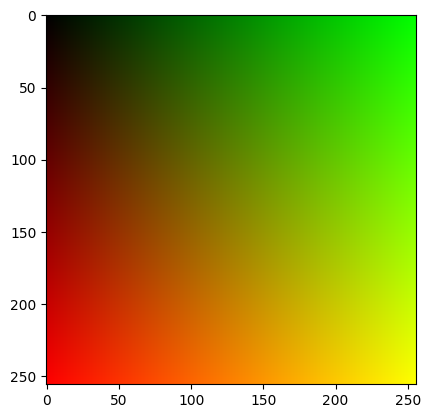

In [284]:
# Hello World PPM - ensure this functions correctly as future code will use similar logic to create, store and view PPM images
def hello_world_ppm():
    ppm_file = 'hello_world.ppm'
    height = width = 256
    create_ppm(ppm_file, width, height, lambda h, w: Color(float(h) / (width - 1), float(w) / (height - 1), 0))
hello_world_ppm()

## Rays, a Simple Camera, and Background

In [285]:
# Ray class
class Ray:
    def __init__(self, origin: Point, direction: Vector3):
        self.origin = origin
        self.direction = direction

#     def at(self, time: float) -> Point:
#         return self.origin + (time * self.direction)
    def at(self, time: float) -> Point:

        scaled_direction = Vector3(self.direction.x * time,
                                   self.direction.y * time,
                                   self.direction.z * time)
        return self.origin + scaled_direction



In [286]:
# Raycast image dimensions
aspect_ratio = 16.0 / 9.0
image_width = 400
image_height = max(1, int(image_width / aspect_ratio))

viewport_height = 2.0
viewport_width = viewport_height * float(image_width) / float(image_height)

# Camera properties
focal_length = 1.0
camera_center = Point(0, 0, 0)

viewport_u = Vector3(viewport_width, 0, 0)
viewport_v = Vector3(0, -viewport_height, 0)

pixel_delta_u = viewport_u / image_width
pixel_delta_v = viewport_v / image_height

viewport_upper_left = camera_center - Vector3(0, 0, focal_length) - (viewport_u / 2) - (viewport_v / 2)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 786.95it/s]


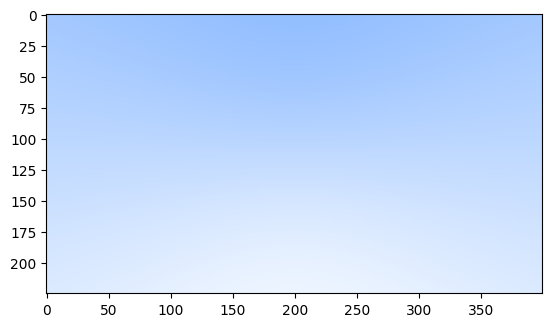

In [287]:
# Skyline PPM -- basic test to ensure Vector, Ray, and aspect ratio math works correctly
pixel00_loc = viewport_upper_left + (pixel_delta_u + pixel_delta_v)*0.5
ppm_file = 'skyline.ppm'

def ray_color(ray: Ray) -> Color:
    unit_direction = ray.direction.unit_vector()
    a = (unit_direction.y + 1.0) * 0.5
    return Color(1.0, 1.0, 1.0)*(1.0-a) + Color(0.5, 0.7, 1.0)*a

def skyline_pixel_color(image_height: int, image_width: int, h: int, w: int) -> Color:
    global pixel_delta_u, pixel_delta_v, pixel00_loc
    pixel_center = pixel00_loc + (pixel_delta_u * w) + (pixel_delta_v * h)
    ray_direction = pixel_center - camera_center
    return ray_color(Ray(camera_center, ray_direction))

create_ppm(ppm_file, image_width, image_height, functools.partial(skyline_pixel_color, image_height, image_width))

## Adding a Sphere

In [288]:
class Sphere:
    def __init__(self, center: Point, radius: float):
        self.center = center
        self.radius = radius

    def hit_sphere(self, ray: Ray) -> bool:
        oc = ray.origin - self.center
        a = ray.direction.dot(ray.direction)
        b = oc.dot(ray.direction) * 2.0
        c = oc.dot(oc) - (self.radius ** 2)
        return ((b*b) - (4*a*c)) >= 0

100%|█████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 701.49it/s]


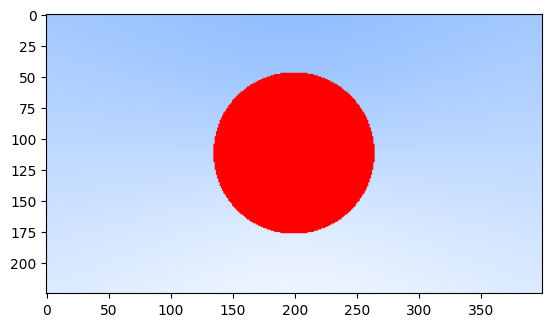

In [289]:
# Raycast sphere (without lighing) -- basic test of sphere ray intersection logic
pixel00_loc = viewport_upper_left + (pixel_delta_u + pixel_delta_v)*0.5
ppm_file = 'solid_sphere.ppm'

def ray_color(sphere: Sphere, ray: Ray) -> Color:
    if (sphere.hit_sphere(ray)):
        return Color(1, 0, 0)
    unit_direction = ray.direction.unit_vector()
    a = (unit_direction.y + 1.0) * 0.5
    return Color(1.0, 1.0, 1.0)*(1.0-a) + Color(0.5, 0.7, 1.0)*a

def solid_sphere_pixel_color(image_height: int, image_width: int, sphere: Sphere, h: int, w: int) -> Color:
    pixel_center = pixel00_loc + (pixel_delta_u * w) + (pixel_delta_v * h)
    ray_direction = pixel_center - camera_center
    return ray_color(sphere, Ray(camera_center, ray_direction))

create_ppm(ppm_file, image_width, image_height, functools.partial(solid_sphere_pixel_color, image_height, image_width, Sphere(Point(0, 0, -1), 0.5)))

## Surface Normals and Multiple Objects

In [290]:
class Sphere:
    def __init__(self, center: Point, radius: float):
        self.center = center
        self.radius = radius

    def hit_sphere(self, ray: Ray) -> bool:
        oc = ray.origin - self.center
        a = ray.direction.dot(ray.direction)
        b = oc.dot(ray.direction) * 2.0
        c = oc.dot(oc) - (self.radius ** 2)
        discriminant = ((b*b) - (4*a*c))
        if discriminant < 0:
            return -1.0
        else:
            return (-b - np.sqrt(discriminant)) / (2.0 * a)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 619.94it/s]


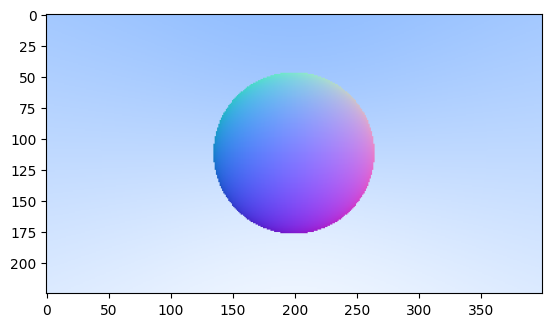

In [291]:
# Raycast sphere with surface normals and multiple objects
pixel00_loc = viewport_upper_left + (pixel_delta_u + pixel_delta_v)*0.5
ppm_file = 'colored_sphere.ppm'

def ray_color(sphere: Sphere, ray: Ray) -> Color:
    t = sphere.hit_sphere(ray)

    if t > 0.0:
        hit_point = ray.at(t)
        normal = (hit_point - sphere.center).unit_vector()
        return Color(normal.x + 1.0, normal.y + 1.0, normal.z + 1.0) * 0.5

    unit_direction = ray.direction.unit_vector()
    a = (unit_direction.y + 1.0) * 0.5
    return Color(1.0, 1.0, 1.0) * (1.0 - a) + Color(0.5, 0.7, 1.0) * a

def solid_sphere_pixel_color(image_height: int, image_width: int, sphere: Sphere, h: int, w: int) -> Color:
    pixel_center = pixel00_loc + (pixel_delta_u * w) + (pixel_delta_v * h)
    ray_direction = pixel_center - camera_center
    return ray_color(sphere, Ray(camera_center, ray_direction))

create_ppm(ppm_file, image_width, image_height, functools.partial(solid_sphere_pixel_color, image_height, image_width, Sphere(Point(0, 0, -1), 0.5)))

### Simplifying Ray-Sphere Intersection

In [292]:
class Interval:
    def __init__(self, min = -np.inf, max = np.inf):
        self.min = min
        self.max = max

    def contains(self, x):
        return self.min <= x and x <= self.max

    def surrounds(self, x):
        return self.min < x and x < self.max

empty: Interval = Interval()
universe: Interval = Interval()

In [293]:
from abc import ABC, abstractmethod

class HitRecord:
    def __init__(self):
        self.point = None
        self.normal = None
        self.t = 0
        self.front_face = False

    def set_face_normal(self, ray, outward_normal):
        self.front_face = ray.direction.dot(outward_normal) < 0
        self.normal = outward_normal if self.front_face else -outward_normal

class Hittable(ABC):
    @abstractmethod
    def hit(self, ray: Ray, interval: Interval, hit_record: HitRecord) -> bool:
        pass


In [294]:
class Sphere(Hittable):
    def __init__(self, center, radius):
        self.center = center
        self.radius = radius

    def hit_sphere(self, ray: Ray) -> float:
        oc = ray.origin - self.center

        a = ray.direction.dot(ray.direction)
        half_b = oc.dot(ray.direction)
        c = oc.dot(oc) - self.radius * self.radius
        discriminant = half_b * half_b - a * c

        if discriminant < 0:
            return -1.0
        else:
            return (-half_b - np.sqrt(discriminant)) / a

    def hit(self, ray: Ray, interval: Interval, hit_record: HitRecord) -> bool:
        oc = ray.origin - self.center
        a = ray.direction.dot(ray.direction)
        half_b = oc.dot(ray.direction)
        c = oc.dot(oc) - self.radius ** 2
        discriminant = half_b**2 - a * c

        if discriminant < 0:
            return False

        sqrtd = np.sqrt(discriminant)
        root = (-half_b - sqrtd) / a
        if not interval.surrounds(root):
            root = (-half_b + sqrtd) / a
            if not interval.surrounds(root):
                return False

        hit_record.t = root
        hit_record.point = ray.at(hit_record.t)
        outward_normal = (hit_record.point - self.center) / self.radius
        hit_record.set_face_normal(ray, outward_normal)

        return True

In [295]:
class HittableList(Hittable):
    def __init__(self, objects=None):
        self.objects = objects if objects is not None else []

    def clear(self):
        self.objects = []

    def add(self, object):
        self.objects.append(object)

    def hit(self, ray: Ray, interval: Interval, hit_record: HitRecord) -> bool:
        temp_record = HitRecord()
        hit_anything = False
        closest_so_far = interval.max

        for obj in self.objects:
            if obj.hit(ray, Interval(interval.min, closest_so_far), temp_record):
                hit_anything = True
                closest_so_far = temp_record.t
                hit_record.point = temp_record.point
                hit_record.normal = temp_record.normal
                hit_record.t = temp_record.t
                hit_record.front_face = temp_record.front_face

        return hit_anything

100%|█████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 419.67it/s]


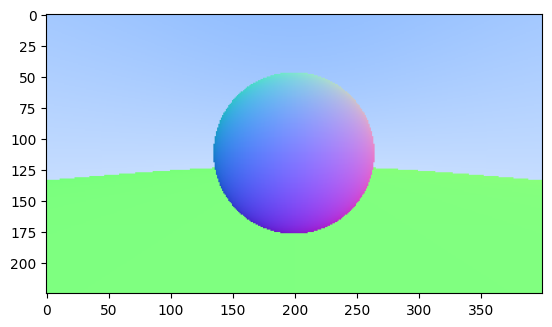

In [296]:
# Raycast sphere with surface normals and multiple objects
pixel00_loc = viewport_upper_left + (pixel_delta_u + pixel_delta_v)*0.5
ppm_file = 'colored_sphere.ppm'

world = HittableList()
world.add(Sphere(Point(0, 0, -1), 0.5))
world.add(Sphere(Point(0, -100.5, -1), 100))


def ray_color(world: HittableList, ray: Ray) -> Color:
    rec = HitRecord()
    if world.hit(ray, Interval(0, np.inf), rec):
        return (Color(rec.normal.x + 1.0, rec.normal.y + 1.0, rec.normal.z + 1.0)) * 0.5

    unit_direction = ray.direction.unit_vector()
    a = (unit_direction.y + 1.0) * 0.5
    return Color(1.0, 1.0, 1.0) * (1.0 - a) + Color(0.5, 0.7, 1.0) * a


def solid_sphere_pixel_color(image_height: int, image_width: int, world: HittableList, h: int, w: int) -> Color:
    pixel_center = pixel00_loc + (pixel_delta_u * w) + (pixel_delta_v * h)
    ray_direction = pixel_center - camera_center
    return ray_color(world, Ray(camera_center, ray_direction))


create_ppm(ppm_file, image_width, image_height, functools.partial(solid_sphere_pixel_color, image_height, image_width, world))


## Moving Camera Code Into Its Own Class

In [297]:
class Camera:
    aspect_ratio  = 1.0
    image_width   = 100

    def render(self, world: Hittable) -> None:
        self.initialize()
        create_ppm(ppm_file, self.image_width, self.image_height, functools.partial(solid_sphere_pixel_color, image_height, image_width, world))

    def initialize(self) -> None:
        global pixel_delta_u, pixel_delta_v, pixel00_loc
        self.image_height = max(1, int(self.image_width / self.aspect_ratio))

        viewport_height = 2.0
        viewport_width = viewport_height * float(self.image_width) / float(self.image_height)

        # Camera properties
        focal_length = 1.0
        camera_center = Point(0, 0, 0)

        viewport_u = Vector3(viewport_width, 0, 0)
        viewport_v = Vector3(0, -viewport_height, 0)

        pixel_delta_u = viewport_u / self.image_width
        pixel_delta_v = viewport_v / self.image_height

        viewport_upper_left = camera_center - Vector3(0, 0, focal_length) - (viewport_u / 2) - (viewport_v / 2)

        pixel00_loc = viewport_upper_left + (pixel_delta_u + pixel_delta_v)*0.5

    def ray_color(self, ray: Ray, world: Hittable) -> Color:
        rec: HitRecord = HitRecord()

        if (world.hit(ray, Interval(0, np.inf), rec)):
            return 0.5 * (rec.normal + Color(1, 1, 1))

        unit_direction = ray.direction.unit_vector()

        a = (unit_direction.y + 1.0) * 0.5
        return Color(1.0, 1.0, 1.0) * (1.0 - a) + Color(0.5, 0.7, 1.0) * a

100%|█████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 414.64it/s]


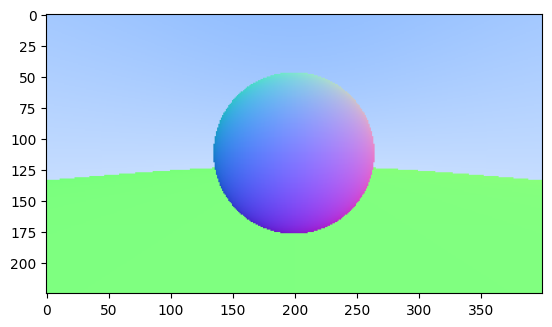

In [298]:
world: HittableList = HittableList()

world.add(Sphere(Point(0, 0, -1), 0.5))
world.add(Sphere(Point(0, -100.5, -1), 100))

camera: Camera = Camera()
camera.aspect_ratio = 16.0 / 9.0
camera.image_width = 400

camera.render(world)

## 8 Antialiasing

In [299]:
class Interval:
    def __init__(self, min = -np.inf, max = np.inf):
        self.min = min
        self.max = max

    def contains(self, x):
        return self.min <= x and x <= self.max

    def surrounds(self, x):
        return self.min < x and x < self.max
    
    def clamp(self, x):
        return max(self.min, min(x, self.max))

empty: Interval = Interval()
universe: Interval = Interval()

In [300]:
def write_color(pixel_color: Color, samples_per_pixel:int) -> str:
    
    r = pixel_color.x
    g = pixel_color.y
    b = pixel_color.z
    
    scale = 1.0 / samples_per_pixel
    
    r *= scale
    g *= scale
    b *= scale
    
    intensity = Interval(0.0, 0.999)
    
    r = intensity.clamp(r)
    g = intensity.clamp(g)
    b = intensity.clamp(b)
    
    return f"{int(255.999 * r)} {int(255.999 * g)} {int(255.999 * b)}\n"

In [301]:
# Create PPM helper function
def create_ppm(ppm_file: str, image_width, image_height, samples_per_pixel, pixel_color: Callable[[int, int], Color]) -> None:
    ppm_image = open(ppm_file, 'w')
    height = width = 256
    ppm_image.write(f"P3\n{image_width} {image_height}\n255\n")
    for h in tqdm(range(image_height)):
        for w in range(image_width):  
            pixel_color = Color(0, 0, 0)
            for sample in range(samples_per_pixel):
                r = camera.get_ray(w,h)
                pixel_color += camera.ray_color(r, world)
                
            ppm_image.write(write_color(pixel_color, samples_per_pixel))  
            
    ppm_image.close()
    img = cv2.imread(ppm_file)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

In [302]:
class Camera:
    aspect_ratio  = 1.0
    image_width   = 100
    samples_per_pixel = 10

    def render(self, world: Hittable) -> None:
        self.initialize()
        create_ppm(ppm_file, self.image_width, self.image_height, self.samples_per_pixel, functools.partial(solid_sphere_pixel_color, image_height, image_width, world))

    def initialize(self) -> None:
        global pixel_delta_u, pixel_delta_v, pixel00_loc
        self.image_height = max(1, int(self.image_width / self.aspect_ratio))
        viewport_height = 2.0
        viewport_width = viewport_height * float(self.image_width) / float(self.image_height)

        # Camera properties
        focal_length = 1.0
        camera_center = Point(0, 0, 0)

        viewport_u = Vector3(viewport_width, 0, 0)
        viewport_v = Vector3(0, -viewport_height, 0)

        pixel_delta_u = viewport_u / self.image_width
        pixel_delta_v = viewport_v / self.image_height

        viewport_upper_left = camera_center - Vector3(0, 0, focal_length) - (viewport_u / 2) - (viewport_v / 2)

        pixel00_loc = viewport_upper_left + (pixel_delta_u + pixel_delta_v)*0.5

    def ray_color(self, ray: Ray, world: Hittable) -> Color:
        rec: HitRecord = HitRecord()
        if (world.hit(ray, Interval(0, np.inf), rec)):
            return 0.5 * (rec.normal + Color(1, 1, 1))

        unit_direction = ray.direction.unit_vector()

        a = (unit_direction.y + 1.0) * 0.5
        return Color(1.0, 1.0, 1.0) * (1.0 - a) + Color(0.5, 0.7, 1.0) * a
    
    def get_ray(self, i, j):        
        pixel_center = pixel00_loc + (i * pixel_delta_u) + (j * pixel_delta_v)
        pixel_sample = pixel_center + self.pixel_sample_square()
        ray_origin = camera_center
        ray_direction = Color(0,0,0)
        ray_direction.x = pixel_sample.x - ray_origin.x
        ray_direction.y = pixel_sample.y - ray_origin.y
        ray_direction.z = pixel_sample.z - ray_origin.z
        
        return Ray(ray_origin, ray_direction)
        
    def pixel_sample_square(self):
        px = -0.5 + random.uniform(0,1)
        py = -0.5 + random.uniform(0,1)
        return px * pixel_delta_u + py * pixel_delta_v

100%|██████████████████████████████████████████████████████████████████████████████████████████| 225/225 [01:02<00:00,  3.62it/s]


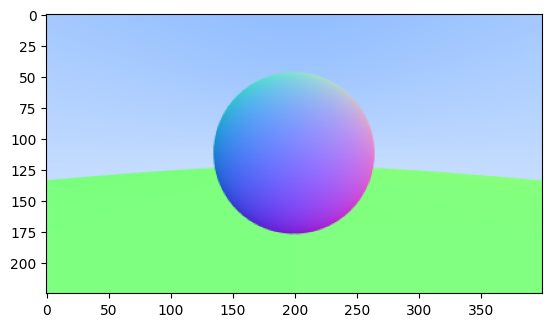

In [303]:
world: HittableList = HittableList()

world.add(Sphere(Point(0, 0, -1), 0.5))
world.add(Sphere(Point(0, -100.5, -1), 100))

camera: Camera = Camera()
camera.aspect_ratio = 16.0 / 9.0
camera.image_width = 400
camera.samples_per_pixel = 100

camera.render(world)

## 9 Diffuse Materials 

In [357]:
class Camera:
    aspect_ratio  = 1.0
    image_width   = 100
    samples_per_pixel = 10

    def render(self, world: Hittable) -> None:
        self.initialize()
        create_ppm(ppm_file, self.image_width, self.image_height, self.samples_per_pixel, functools.partial(solid_sphere_pixel_color, image_height, image_width, world))

    def initialize(self) -> None:
        global pixel_delta_u, pixel_delta_v, pixel00_loc
        self.image_height = max(1, int(self.image_width / self.aspect_ratio))
        viewport_height = 2.0
        viewport_width = viewport_height * float(self.image_width) / float(self.image_height)

        # Camera properties
        focal_length = 1.0
        camera_center = Point(0, 0, 0)

        viewport_u = Vector3(viewport_width, 0, 0)
        viewport_v = Vector3(0, -viewport_height, 0)

        pixel_delta_u = viewport_u / self.image_width
        pixel_delta_v = viewport_v / self.image_height

        viewport_upper_left = camera_center - Vector3(0, 0, focal_length) - (viewport_u / 2) - (viewport_v / 2)

        pixel00_loc = viewport_upper_left + (pixel_delta_u + pixel_delta_v)*0.5

    # Optimization need to set depth to limit number recursion calls to maybe 50 !!!
    def ray_color(self, ray: Ray, world: Hittable) -> Color:
        rec: HitRecord = HitRecord()
        if (world.hit(ray, Interval(0, np.inf), rec)):
            direction = Vector3.random_on_hemisphere(rec.normal)
            return 0.5 * self.ray_color(Ray(rec.point, direction), world)
        unit_direction = ray.direction.unit_vector()

        a = (unit_direction.y + 1.0) * 0.5
        return Color(1.0, 1.0, 1.0) * (1.0 - a) + Color(0.5, 0.7, 1.0) * a
    
    def get_ray(self, i, j):        
        pixel_center = pixel00_loc + (i * pixel_delta_u) + (j * pixel_delta_v)
        pixel_sample = pixel_center + self.pixel_sample_square()
        ray_origin = camera_center
        ray_direction = Color(0,0,0)
        ray_direction.x = pixel_sample.x - ray_origin.x
        ray_direction.y = pixel_sample.y - ray_origin.y
        ray_direction.z = pixel_sample.z - ray_origin.z
        
        return Ray(ray_origin, ray_direction)
        
    def pixel_sample_square(self):
        px = -0.5 + random.uniform(0,1)
        py = -0.5 + random.uniform(0,1)
        return px * pixel_delta_u + py * pixel_delta_v

100%|██████████████████████████████████████████████████████████████████████████████████████████| 225/225 [03:31<00:00,  1.06it/s]


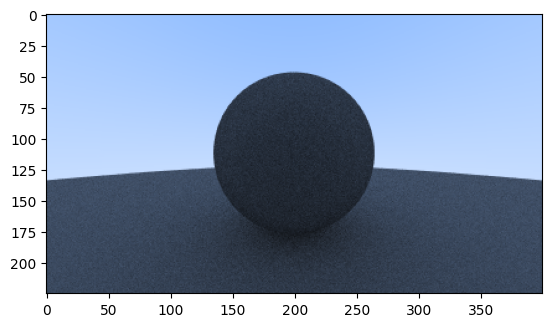

In [358]:
world: HittableList = HittableList()

world.add(Sphere(Point(0, 0, -1), 0.5))
world.add(Sphere(Point(0, -100.5, -1), 100))

camera: Camera = Camera()
camera.aspect_ratio = 16.0 / 9.0
camera.image_width = 400
camera.samples_per_pixel = 100

camera.render(world)

In [ ]:
# Note it has become slower because of the recursive calls in ray_color, we can possibly fix this my setting a max
# recursion depth